### Import data

In [27]:
using Pkg
Pkg.instantiate()
using DrugResponseModel

# import data from the path
conc_l, pop, g2, g1, g2_0, g1_0 = setup_data("lapatinib");# in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0

### Estimate 

In [2]:
# ODE optimization and estimation of the parameters
params_ode = zeros(4, 8)
for i in 1:8
    fit, params_ode[:, i] = ODEoptimizer([1.0, 1.0, 0.0, 0.0], i, g1, g2, g1_0, g2_0)
    print(fit, "\n")
end

499.7844523366607
393.6081104729332
649.4302062578748
1538.3608818667622
2854.297465245645
2337.4362823644724
652.6135770317079
666.0668623992713


In [3]:
p = params_ode

4×8 Array{Float64,2}:
 0.174238   0.0370436    0.0418661   …  0.0466356   0.0146481    0.00546761
 0.0937869  0.0239965    0.0283289      0.100265    0.0701577    0.0452781 
 0.0350556  0.000486542  0.0016963      0.031723    0.014548     0.00932652
 0.0404115  0.00015581   0.00100524     0.00487713  0.000146249  0.00010007

### Turing

In [50]:
using Turing, RecursiveArrayTools, ParameterizedFunctions, DifferentialEquations

t = range(0.0; stop = 95.5, length = 192)
i=7
function update_coef(A, u, p, t)
    A[:, :] .= [-p[1]-p[3] 2*p[2]; p[1] -p[2]-p[4]]
end

""" Predicts the model given a set of parametrs. """

u0 = [g1_0[i], g2_0[i]]
A = zeros(eltype(p), 2, 2)
update_coef(A, nothing, p, nothing)
Op = DiffEqArrayOperator(A, update_func=update_coef)
prob = ODEProblem(Op, u0, extrema(t), p)
sol = solve(prob, AutoTsit5(Rosenbrock23()))

newsol = zeros(2, 192)
newsol[1, :] = sol(t, idxs=1).u
newsol[2, :] = sol(t, idxs=2).u

function remakeProblem(p, SaveAt)
  _prob = remake(prob;u0=convert.(eltype(p),prob.u0),p=p)
  solve(_prob,AutoTsit5(Rosenbrock23()), saveat=SaveAt;abstol=1e-6, reltol= 1e-6)
end

@model bayesODE(x, tp) = begin
  alpha ~ Uniform(0.0, 2.0)
  beta ~ Uniform(0.0, 2.0)
  gamma1 ~ Uniform(0.0, 2.0)
  gamma2 ~ Uniform(0.0, 2.0)

  # gather parameters and solve equation
  p = [alpha, beta, gamma1 ,gamma2]
  sol_tmp = test_f(p, tp)
  # hope that it's likelihood
  N = length(tp)

  fill_length = length(tp) - length(sol_tmp.u)

  for i in 1:fill_length
    if eltype(sol_tmp.u) <: Number
      push!(sol_tmp.u, Inf)
    else
      push!(sol_tmp.u, fill(Inf, size(sol_tmp[1])))
    end
  end


  for i in 1:N
    x[:,i] ~ MvNormal(sol_tmp.u[i], [0.5,0.5])
  end
end

bayesODE (generic function with 3 methods)

In [51]:
newsol

2×192 Array{Float64,2}:
 13.2625    8.81291   7.35754  …  2270.78  2343.63  2418.8   2496.29
  6.73754  10.3834   11.9385      4436.58  4578.91  4725.77  4877.16

In [52]:
tp = collect(range(0, stop=95.5))
chain = sample(bayesODE(newsol, tp), Turing.NUTS(0.65), 500)

TypeError: TypeError: in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,4}

### An example that works!

In [30]:
using DifferentialEquations, Plots, ParameterizedFunctions, Random, Distributions, Turing, StatsPlots, RecursiveArrayTools

predator_prey = @ode_def begin
    du = (alpha - beta*v) * u
    dv = (-gamma + delta * u) * v
    end alpha beta gamma delta

#  "Experimental" data generation
u0 = [10.0, 10.0]
tspan = (0.0, 40.0)
p = [1.1,0.4,0.4, 0.1]
tp= collect(range(0,stop=40))
prob = ODEProblem(predator_prey, u0, tspan, p)
sol = solve(prob, saveat=tp)
# optional plot
# plot(sol, linestyle=:dot)
# modify data with adding gaussian noise
d1 = Normal(0, 0.5)
d2 = Normal(0, 0.5)
newsol = VectorOfArray(sol.u)[:,:]

newsol[1,:] = newsol[1,:] + rand(d1,length(tp))
newsol[2,:] = newsol[2,:] + rand(d2,length(tp))

function test_f(p, tp_save)
  _prob = remake(prob;u0=convert.(eltype(p),prob.u0),p=p)
  solve(_prob,Rodas4(),saveat=tp_save;abstol=1e-6, reltol= 1e-6)
end

plot(sol)
scatter!(tp,newsol[1,:])
scatter!(tp,newsol[2,:])

# define statistical model
@model bayes_predator_prey(x, tp_x) = begin
  alpha ~ Normal(1.0, 0.2)
  beta ~ Normal(0.5, 0.2)
  gamma ~ Normal(0.5, 0.2)
  delta ~ Normal(0.1, 0.1)
  # gather parameters and solve equation
  p = [alpha, beta, gamma ,delta]
  sol_tmp = test_f(p, tp_x)
  # hope that it's likelihood
  N = length(tp_x)

  fill_length = length(tp_x) - length(sol_tmp.u)

  for i in 1:fill_length
    if eltype(sol_tmp.u) <: Number
      push!(sol_tmp.u, Inf)
    else
      push!(sol_tmp.u, fill(Inf, size(sol_tmp[1])))
    end
  end


  for i in 1:N
    x[:,i] ~ MvNormal(sol_tmp.u[i], [0.5,0.5])
  end
end

# run the sampling
chain = sample(bayes_predator_prey(newsol, tp), NUTS(0.65), 100)


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/farnazm/.julia/packages/DiffEqBase/cwiDm/src/integrator_interface.jl:333
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/farnazm/.julia/packages/AdvancedHMC/1ngch/src/hamiltonian.jl:45
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/farnazm/.julia/packages/DiffEqBase/cwiDm/src/integrator_interface.jl:333
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/farnazm/.julia/packages/AdvancedHMC/1ngch/src/hamiltonian.jl:45
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, fals

Object of type Chains, with data of type 50×16×1 Array{Union{Missing, Real},3}

Iterations        = 1:50
Thinning interval = 1
Chains            = 1
Samples per chain = 50
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = alpha, beta, delta, gamma

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std       │ naive_se   │ mcse    │ ess     │
│     │ Symbol     │ Float64  │ Float64   │ Float64    │ Missing │ Any     │
├─────┼────────────┼──────────┼───────────┼────────────┼─────────┼─────────┤
│ 1   │ alpha      │ 4.03027  │ 0.380663  │ 0.0538339  │ missing │ 3.33766 │
│ 2   │ beta       │ 1.80636  │ 0.124694  │ 0.0176344  │ missing │ 2.33381 │
│ 3   │ delta      │ 0.255618 │ 0.0510399 │ 0.00721813 │ missing │ 3.4733  │
│ 4   │ gamma      │ 0.63971 

In [31]:
newsol

2×41 Array{Float64,2}:
 10.1766   -0.138577  -0.255948  0.165028  …  1.11593   2.38215   5.0889  
  9.80254   9.71809    6.02845   4.24879      0.531611  0.490834  0.837635

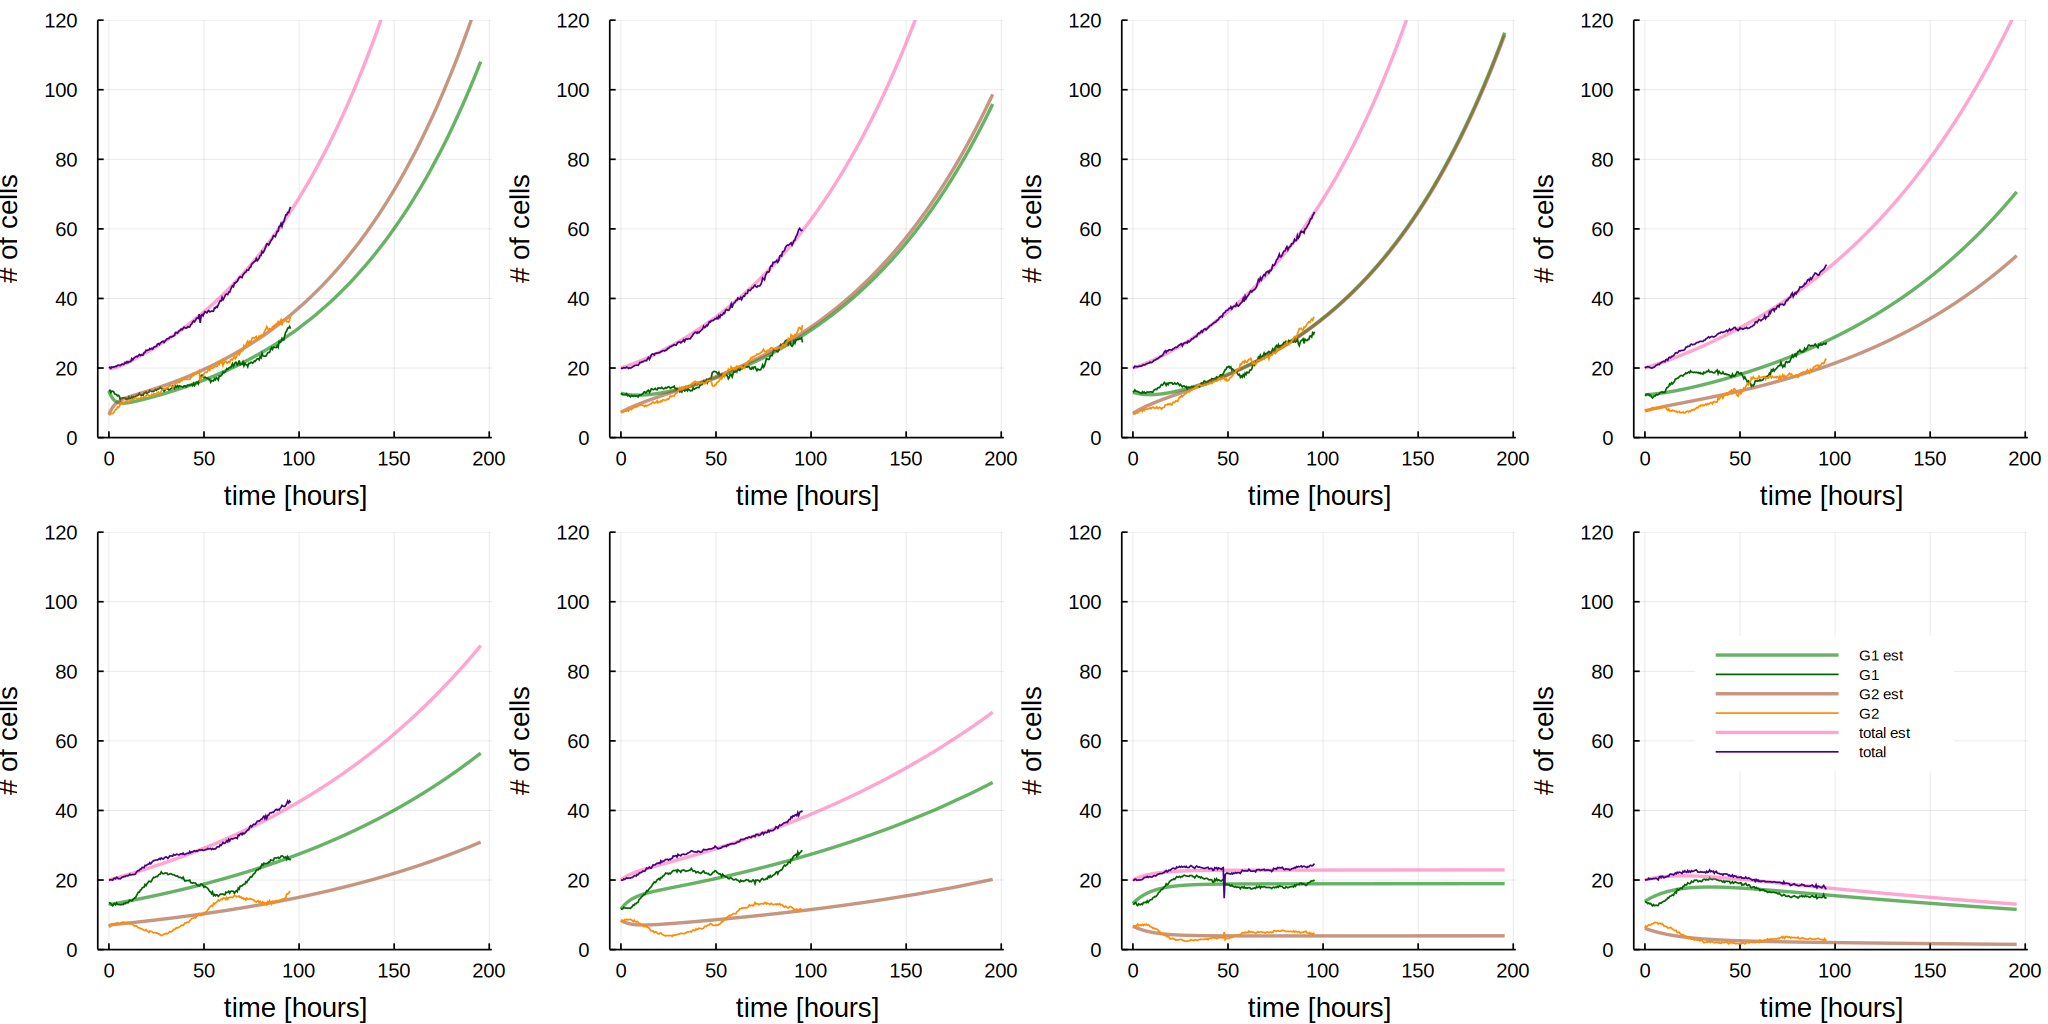

In [6]:
# plotting the fitted curves
ODEplot_all(params_ode, g1, g2, g1_0, g2_0, pop)